<a href="https://colab.research.google.com/github/minkyeongk/DL_TensorFlow_Developer/blob/main/4.%20Sequences%2C%20Time%20Series%20and%20Prediction/week_2/week_2_notebook2_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predict value using DNN, Adjust Learning Rate 

In [9]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.0


In [11]:
# 데이터 합성
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

In [12]:
split_time = 1000   # train val 나누는 기준선 
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20  # 데이터 몇개씩 묶을건지 
batch_size = 32   # windowed 된 데이터 몇개씩 묶을건지
shuffle_buffer_size = 1000  # train data 개수 총 1000개  

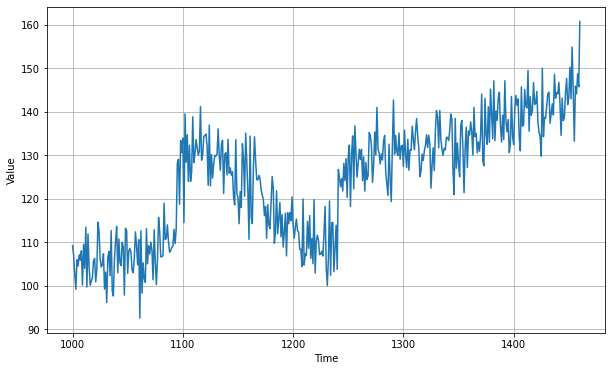

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [16]:
# windowed dataset 만드는 선처리 함수 
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer_size).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [17]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),  # input_shape > window_size
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)) # 여기서 momentum이 의미하는 바가 뭔지 
model.fit(dataset, epochs=100, verbose=0)

[array([[100.83474]], dtype=float32), array([[99.95162]], dtype=float32), array([[104.26926]], dtype=float32), array([[102.97196]], dtype=float32), array([[100.869934]], dtype=float32), array([[101.99981]], dtype=float32), array([[102.53275]], dtype=float32), array([[102.59118]], dtype=float32), array([[102.50733]], dtype=float32), array([[103.36139]], dtype=float32), array([[103.05172]], dtype=float32), array([[105.58622]], dtype=float32), array([[104.07796]], dtype=float32), array([[105.26053]], dtype=float32), array([[102.183815]], dtype=float32), array([[107.122734]], dtype=float32), array([[103.361694]], dtype=float32), array([[105.312904]], dtype=float32), array([[102.51437]], dtype=float32), array([[101.97619]], dtype=float32), array([[104.04919]], dtype=float32), array([[102.49919]], dtype=float32), array([[103.74125]], dtype=float32), array([[101.64515]], dtype=float32), array([[103.98592]], dtype=float32), array([[104.437706]], dtype=float32), array([[106.18021]], dtype=float

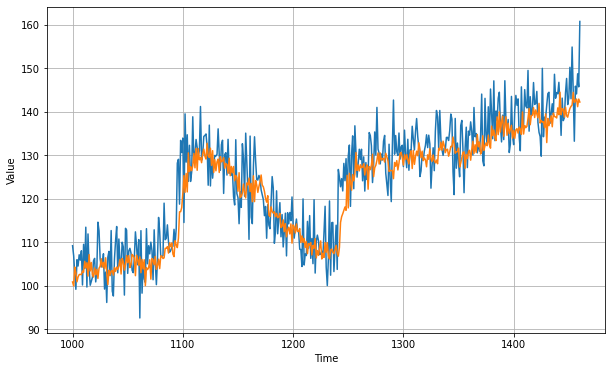

In [18]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))   # 모델에서 사용하는 입력 치수로 모양 변경 

forecast = forecast[split_time-window_size:]
print(forecast)
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.7498083

In [21]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))    # epoch에 따라 lr 변경해가며 최적값 찾을 예정 
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss='mse', optimizer=optimizer)  
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

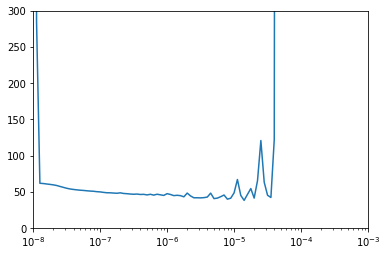

In [23]:
lrs = 1e-8 * (10 ** (np.arange(100)/20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [24]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)    # 결과 반영하여 lr 수정 
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

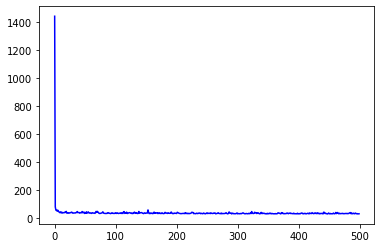

In [25]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[45.35758590698242, 37.579795837402344, 41.74632263183594, 36.97612762451172, 39.47654342651367, 38.80160140991211, 39.30061340332031, 43.876644134521484, 40.1578254699707, 48.07017135620117, 35.559940338134766, 36.655364990234375, 35.50086975097656, 38.70657730102539, 36.178955078125, 37.41452407836914, 39.276268005371094, 41.15907287597656, 43.02189636230469, 36.396636962890625, 38.049503326416016, 35.86814880371094, 36.59291458129883, 37.557621002197266, 36.836910247802734, 39.58241653442383, 40.050880432128906, 47.2397575378418, 39.10948944091797, 39.805992126464844, 40.674747467041016, 35.4811897277832, 39.46904373168945, 38.76984405517578, 38.32706069946289, 47.224422454833984, 38.69969940185547, 39.7398681640625, 43.66049575805664, 33.6268310546875, 36.91472625732422, 34.79008865356445, 45.22581481933594, 35.62089538574219, 38.73397445678711, 44.9841194152832, 38.18904113769531, 35.559593200683594, 37.9425163269043, 36.59604263305664, 33.84406661987305, 36.36301803588867, 38.942

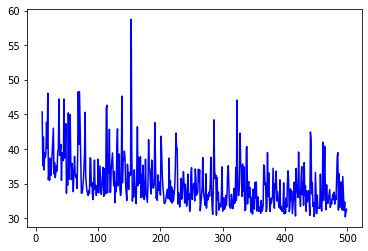

In [26]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

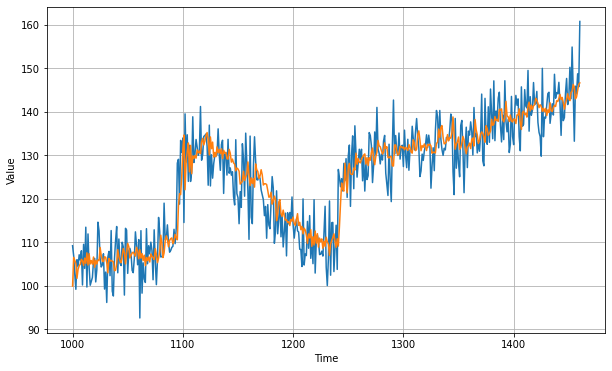

In [27]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]      # forecast[split_time-window_size]가 split time 시점의 예측값
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [28]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.464413